In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, Normalizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

import plotly.graph_objects as go
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud

In [2]:
df_artists = pd.read_csv('artists.csv', index_col='artist', converters={'genres': literal_eval, 'albums': literal_eval,
                                                                        'related_artists':literal_eval, 'related_genres':literal_eval})

## Data wrangling

Impute empty genres with related genres

In [3]:
df_artists.loc[df_artists['genres'].apply(lambda x: len(x) == 0), 'genres'] = df_artists['related_genres']

In [4]:
mlb = MultiLabelBinarizer()
mlb.fit(df_artists['genres'])

MultiLabelBinarizer(classes=None, sparse_output=False)

One-hot encode genres

In [5]:
df_genres = pd.DataFrame(data=mlb.transform(df_artists['genres']), 
                         columns=['genre: {}'.format(genre) for genre in mlb.classes_],
                         index=df_artists.index)

In [6]:
df_artists = df_artists.join(df_genres)
df_artists.head()

artist_id  followers  \
artist                                                       
Travis Scott             0Y5tJX1MQlPlqiwlOH1tJY    7697676   
Martin Garrix            60d24wfXkVzDSfLS6hyCjZ   12566165   
Los Fabulosos Cadillacs  2FS22haX3FYbyOsUAkuYqZ    1671946   
Brockhampton             1Bl6wpkWCQ4KVgnASpvzzA    1183998   
DUKI                     1bAftSH8umNcGZ0uyV7LMg    2712196   

                                                                    genres  \
artist                                                                       
Travis Scott                                                         [rap]   
Martin Garrix            [big room, edm, pop, progressive house, tropic...   
Los Fabulosos Cadillacs  [argentine rock, latin alternative, latin rock...   
Brockhampton                                 [boy band, hip hop, pop, rap]   
DUKI                                   [argentine hip hop, trap argentino]   

                         popularity  \
artist                                
Travis Scott                     98   
Martin Garrix                    88   
Los Fabulosos Cadillacs          73   
Brockhampton                     85   
DUKI                             84   

                                                                    albums  \
artist                                                                       
Travis Scott             {'2019-12-27': 'JACKBOYS', '2018-11-06': 'NOT ...   
Martin Garrix            {'2019-07-10': 'The Martin Garrix Experience',...   
Los Fabulosos Cadillacs  {'2017-10-20': 'En Vivo en The Theater at Madi...   
Brockhampton             {'2019-08-23': 'GINGER', '2018-09-21': 'irides...   
DUKI                     {'2019-11-01': 'Súper Sangre Joven', '2020-01-...   

                                                           related_artists  \
artist                                                                       
Travis Scott             [A$AP Rocky, Chief Keef, KIDS SEE GHOSTS, Push...   
Martin Garrix            [AREA21, Brooks, Deorro, Lucas & Steve, KAAZE,...   
Los Fabulosos Cadillacs  [Los Pericos, Vicentico, Aterciopelados, Los A...   
Brockhampton             [Kevin Abstract, Matt Champion, JPEGMAFIA, Ame...   
DUKI                     [Uriel Natero, Bhavi, KHEA, Lit Killah, Seven ...   

                                                            related_genres  \
artist                                                                       
Travis Scott             [east coast hip hop, hip hop, pop rap, rap, tr...   
Martin Garrix            [big room, edm, big room, deep big room, edm, ...   
Los Fabulosos Cadillacs  [argentine reggae, argentine rock, latin alter...   
Brockhampton             [alternative r&b, hip hop, lgbtq+ hip hop, rap...   
DUKI                     [argentine hip hop, trap argentino, argentine ...   

                         day  genre: alternative r&b  genre: alternative rock  \
artist                                                                          
Travis Scott               1                       0                        0   
Martin Garrix              1                       0                        0   
Los Fabulosos Cadillacs    1                       0                        0   
Brockhampton               1                       0                        0   
DUKI                       1                       0                        0   

                         ...  genre: trap argentino  genre: trap chileno  \
artist                   ...                                               
Travis Scott             ...                      0                    0   
Martin Garrix            ...                      0                    0   
Los Fabulosos Cadillacs  ...                      0                    0   
Brockhampton             ...                      0                    0   
DUKI                     ...                      1                    0   

                         genre: trap esp

One-hot encode related artists

In [7]:
mlb.fit(df_artists['related_artists'])
df_related_artists = pd.DataFrame(data=mlb.transform(df_artists['related_artists']), 
                                  columns=['related_artist: {}'.format(related_artist) for related_artist in mlb.classes_],
                                  index=df_artists.index)

In [8]:
df_artists = df_artists.join(df_related_artists)
df_artists.head()

artist_id  followers  \
artist                                                       
Travis Scott             0Y5tJX1MQlPlqiwlOH1tJY    7697676   
Martin Garrix            60d24wfXkVzDSfLS6hyCjZ   12566165   
Los Fabulosos Cadillacs  2FS22haX3FYbyOsUAkuYqZ    1671946   
Brockhampton             1Bl6wpkWCQ4KVgnASpvzzA    1183998   
DUKI                     1bAftSH8umNcGZ0uyV7LMg    2712196   

                                                                    genres  \
artist                                                                       
Travis Scott                                                         [rap]   
Martin Garrix            [big room, edm, pop, progressive house, tropic...   
Los Fabulosos Cadillacs  [argentine rock, latin alternative, latin rock...   
Brockhampton                                 [boy band, hip hop, pop, rap]   
DUKI                                   [argentine hip hop, trap argentino]   

                         popularity  \
artist                                
Travis Scott                     98   
Martin Garrix                    88   
Los Fabulosos Cadillacs          73   
Brockhampton                     85   
DUKI                             84   

                                                                    albums  \
artist                                                                       
Travis Scott             {'2019-12-27': 'JACKBOYS', '2018-11-06': 'NOT ...   
Martin Garrix            {'2019-07-10': 'The Martin Garrix Experience',...   
Los Fabulosos Cadillacs  {'2017-10-20': 'En Vivo en The Theater at Madi...   
Brockhampton             {'2019-08-23': 'GINGER', '2018-09-21': 'irides...   
DUKI                     {'2019-11-01': 'Súper Sangre Joven', '2020-01-...   

                                                           related_artists  \
artist                                                                       
Travis Scott             [A$AP Rocky, Chief Keef, KIDS SEE GHOSTS, Push...   
Martin Garrix            [AREA21, Brooks, Deorro, Lucas & Steve, KAAZE,...   
Los Fabulosos Cadillacs  [Los Pericos, Vicentico, Aterciopelados, Los A...   
Brockhampton             [Kevin Abstract, Matt Champion, JPEGMAFIA, Ame...   
DUKI                     [Uriel Natero, Bhavi, KHEA, Lit Killah, Seven ...   

                                                            related_genres  \
artist                                                                       
Travis Scott             [east coast hip hop, hip hop, pop rap, rap, tr...   
Martin Garrix            [big room, edm, big room, deep big room, edm, ...   
Los Fabulosos Cadillacs  [argentine reggae, argentine rock, latin alter...   
Brockhampton             [alternative r&b, hip hop, lgbtq+ hip hop, rap...   
DUKI                     [argentine hip hop, trap argentino, argentine ...   

                         day  genre: alternative r&b  genre: alternative rock  \
artist                                                                          
Travis Scott               1                       0                        0   
Martin Garrix              1                       0                        0   
Los Fabulosos Cadillacs    1                       0                        0   
Brockhampton               1                       0                        0   
DUKI                       1                       0                        0   

                         ...  related_artist: lovelytheband  \
artist                   ...                                  
Travis Scott             ...                              0   
Martin Garrix            ...                              0   
Los Fabulosos Cadillacs  ...                              0   
Brockhampton             ...                              0   
DUKI                     ...                              0   

                         related_artist: sfam  related_artist: slowthai  \
artist                                                  

Weight related genres

In [9]:
df_related_genres = df_artists['related_genres'].apply(lambda x: pd.Series(x).value_counts())
df_related_genres.columns = ['related_genre: '+c for c in df_related_genres.columns]
df_related_genres.fillna(0, inplace=True)

In [10]:
df_artists = df_artists.join(df_related_genres)
df_artists.head()

artist_id  followers  \
artist                                                       
Travis Scott             0Y5tJX1MQlPlqiwlOH1tJY    7697676   
Martin Garrix            60d24wfXkVzDSfLS6hyCjZ   12566165   
Los Fabulosos Cadillacs  2FS22haX3FYbyOsUAkuYqZ    1671946   
Brockhampton             1Bl6wpkWCQ4KVgnASpvzzA    1183998   
DUKI                     1bAftSH8umNcGZ0uyV7LMg    2712196   

                                                                    genres  \
artist                                                                       
Travis Scott                                                         [rap]   
Martin Garrix            [big room, edm, pop, progressive house, tropic...   
Los Fabulosos Cadillacs  [argentine rock, latin alternative, latin rock...   
Brockhampton                                 [boy band, hip hop, pop, rap]   
DUKI                                   [argentine hip hop, trap argentino]   

                         popularity  \
artist                                
Travis Scott                     98   
Martin Garrix                    88   
Los Fabulosos Cadillacs          73   
Brockhampton                     85   
DUKI                             84   

                                                                    albums  \
artist                                                                       
Travis Scott             {'2019-12-27': 'JACKBOYS', '2018-11-06': 'NOT ...   
Martin Garrix            {'2019-07-10': 'The Martin Garrix Experience',...   
Los Fabulosos Cadillacs  {'2017-10-20': 'En Vivo en The Theater at Madi...   
Brockhampton             {'2019-08-23': 'GINGER', '2018-09-21': 'irides...   
DUKI                     {'2019-11-01': 'Súper Sangre Joven', '2020-01-...   

                                                           related_artists  \
artist                                                                       
Travis Scott             [A$AP Rocky, Chief Keef, KIDS SEE GHOSTS, Push...   
Martin Garrix            [AREA21, Brooks, Deorro, Lucas & Steve, KAAZE,...   
Los Fabulosos Cadillacs  [Los Pericos, Vicentico, Aterciopelados, Los A...   
Brockhampton             [Kevin Abstract, Matt Champion, JPEGMAFIA, Ame...   
DUKI                     [Uriel Natero, Bhavi, KHEA, Lit Killah, Seven ...   

                                                            related_genres  \
artist                                                                       
Travis Scott             [east coast hip hop, hip hop, pop rap, rap, tr...   
Martin Garrix            [big room, edm, big room, deep big room, edm, ...   
Los Fabulosos Cadillacs  [argentine reggae, argentine rock, latin alter...   
Brockhampton             [alternative r&b, hip hop, lgbtq+ hip hop, rap...   
DUKI                     [argentine hip hop, trap argentino, argentine ...   

                         day  genre: alternative r&b  genre: alternative rock  \
artist                                                                          
Travis Scott               1                       0                        0   
Martin Garrix              1                       0                        0   
Los Fabulosos Cadillacs    1                       0                        0   
Brockhampton               1                       0                        0   
DUKI                       1                       0                        0   

                         ...  related_genre: nu disco  \
artist                   ...                            
Travis Scott             ...                      0.0   
Martin Garrix            ...                      0.0   
Los Fabulosos Cadillacs  ...                      0.0   
Brockhampton             ...                      0.0   
DUKI                     ...                      0.0   

                         related_genre: minimal tech house  \
artist                                                       
Travis Scott                                     

One-hot encode argentinian artists

In [11]:
is_argentinian = pd.read_csv('is_argentinian.csv', index_col='artist')

In [12]:
df_artists = df_artists.join(is_argentinian)
df_artists.head()

artist_id  followers  \
artist                                                       
Travis Scott             0Y5tJX1MQlPlqiwlOH1tJY    7697676   
Martin Garrix            60d24wfXkVzDSfLS6hyCjZ   12566165   
Los Fabulosos Cadillacs  2FS22haX3FYbyOsUAkuYqZ    1671946   
Brockhampton             1Bl6wpkWCQ4KVgnASpvzzA    1183998   
DUKI                     1bAftSH8umNcGZ0uyV7LMg    2712196   

                                                                    genres  \
artist                                                                       
Travis Scott                                                         [rap]   
Martin Garrix            [big room, edm, pop, progressive house, tropic...   
Los Fabulosos Cadillacs  [argentine rock, latin alternative, latin rock...   
Brockhampton                                 [boy band, hip hop, pop, rap]   
DUKI                                   [argentine hip hop, trap argentino]   

                         popularity  \
artist                                
Travis Scott                     98   
Martin Garrix                    88   
Los Fabulosos Cadillacs          73   
Brockhampton                     85   
DUKI                             84   

                                                                    albums  \
artist                                                                       
Travis Scott             {'2019-12-27': 'JACKBOYS', '2018-11-06': 'NOT ...   
Martin Garrix            {'2019-07-10': 'The Martin Garrix Experience',...   
Los Fabulosos Cadillacs  {'2017-10-20': 'En Vivo en The Theater at Madi...   
Brockhampton             {'2019-08-23': 'GINGER', '2018-09-21': 'irides...   
DUKI                     {'2019-11-01': 'Súper Sangre Joven', '2020-01-...   

                                                           related_artists  \
artist                                                                       
Travis Scott             [A$AP Rocky, Chief Keef, KIDS SEE GHOSTS, Push...   
Martin Garrix            [AREA21, Brooks, Deorro, Lucas & Steve, KAAZE,...   
Los Fabulosos Cadillacs  [Los Pericos, Vicentico, Aterciopelados, Los A...   
Brockhampton             [Kevin Abstract, Matt Champion, JPEGMAFIA, Ame...   
DUKI                     [Uriel Natero, Bhavi, KHEA, Lit Killah, Seven ...   

                                                            related_genres  \
artist                                                                       
Travis Scott             [east coast hip hop, hip hop, pop rap, rap, tr...   
Martin Garrix            [big room, edm, big room, deep big room, edm, ...   
Los Fabulosos Cadillacs  [argentine reggae, argentine rock, latin alter...   
Brockhampton             [alternative r&b, hip hop, lgbtq+ hip hop, rap...   
DUKI                     [argentine hip hop, trap argentino, argentine ...   

                         day  genre: alternative r&b  genre: alternative rock  \
artist                                                                          
Travis Scott               1                       0                        0   
Martin Garrix              1                       0                        0   
Los Fabulosos Cadillacs    1                       0                        0   
Brockhampton               1                       0                        0   
DUKI                       1                       0                        0   

                         ...  related_genre: minimal tech house  \
artist                   ...                                      
Travis Scott             ...                                0.0   
Martin Garrix            ...                                0.0   
Los Fabulosos Cadillacs  ...                                0.0   
Brockhampton             ...                                0.0   
DUKI                     ...                                0.0   

                         related_genre: electro swing  \
artist                                        

Year of the first release

In [13]:
first_release = lambda x: pd.DatetimeIndex(pd.Series(df_artists.loc[x]['albums']).index).min().year

In [14]:
df_artists['first_release'] = df_artists.index.map(first_release)
df_artists.head()

artist_id  followers  \
artist                                                       
Travis Scott             0Y5tJX1MQlPlqiwlOH1tJY    7697676   
Martin Garrix            60d24wfXkVzDSfLS6hyCjZ   12566165   
Los Fabulosos Cadillacs  2FS22haX3FYbyOsUAkuYqZ    1671946   
Brockhampton             1Bl6wpkWCQ4KVgnASpvzzA    1183998   
DUKI                     1bAftSH8umNcGZ0uyV7LMg    2712196   

                                                                    genres  \
artist                                                                       
Travis Scott                                                         [rap]   
Martin Garrix            [big room, edm, pop, progressive house, tropic...   
Los Fabulosos Cadillacs  [argentine rock, latin alternative, latin rock...   
Brockhampton                                 [boy band, hip hop, pop, rap]   
DUKI                                   [argentine hip hop, trap argentino]   

                         popularity  \
artist                                
Travis Scott                     98   
Martin Garrix                    88   
Los Fabulosos Cadillacs          73   
Brockhampton                     85   
DUKI                             84   

                                                                    albums  \
artist                                                                       
Travis Scott             {'2019-12-27': 'JACKBOYS', '2018-11-06': 'NOT ...   
Martin Garrix            {'2019-07-10': 'The Martin Garrix Experience',...   
Los Fabulosos Cadillacs  {'2017-10-20': 'En Vivo en The Theater at Madi...   
Brockhampton             {'2019-08-23': 'GINGER', '2018-09-21': 'irides...   
DUKI                     {'2019-11-01': 'Súper Sangre Joven', '2020-01-...   

                                                           related_artists  \
artist                                                                       
Travis Scott             [A$AP Rocky, Chief Keef, KIDS SEE GHOSTS, Push...   
Martin Garrix            [AREA21, Brooks, Deorro, Lucas & Steve, KAAZE,...   
Los Fabulosos Cadillacs  [Los Pericos, Vicentico, Aterciopelados, Los A...   
Brockhampton             [Kevin Abstract, Matt Champion, JPEGMAFIA, Ame...   
DUKI                     [Uriel Natero, Bhavi, KHEA, Lit Killah, Seven ...   

                                                            related_genres  \
artist                                                                       
Travis Scott             [east coast hip hop, hip hop, pop rap, rap, tr...   
Martin Garrix            [big room, edm, big room, deep big room, edm, ...   
Los Fabulosos Cadillacs  [argentine reggae, argentine rock, latin alter...   
Brockhampton             [alternative r&b, hip hop, lgbtq+ hip hop, rap...   
DUKI                     [argentine hip hop, trap argentino, argentine ...   

                         day  genre: alternative r&b  genre: alternative rock  \
artist                                                                          
Travis Scott               1                       0                        0   
Martin Garrix              1                       0                        0   
Los Fabulosos Cadillacs    1                       0                        0   
Brockhampton               1                       0                        0   
DUKI                       1                       0                        0   

                         ...  related_genre: electro swing  \
artist                   ...                                 
Travis Scott             ...                           0.0   
Martin Garrix            ...                           0.0   
Los Fabulosos Cadillacs  ...                           0.0   
Brockhampton             ...                           0.0   
DUKI                     ...                           0.0   

                         related_genre: filter house  related_genre: bboy  \
artist                                                       

---

## Exploratory Data Analysis

Quantity of artists per day

In [15]:
df_artists.groupby('day')[['artist_id']].count()

artist_id
day           
1           32
2           31
3           28

Proportion of argentinian artists per day

In [16]:
df_artists.groupby('day')[['is_argentinian']].mean().round(2)

is_argentinian
day                
1              0.41
2              0.35
3              0.29

Followers distribution

In [17]:
fig = go.Figure(data=[go.Histogram(x=df_artists['followers'])])
fig.update_layout(title={'text':'Followers distribution', 'x':0.5}, plot_bgcolor='rgba(0,0,0,0)')
fig.update_yaxes(showgrid=True, gridwidth=.5, gridcolor='lightgray')
fig.show()

Identify most followed artists

In [18]:
df_artists.loc[df_artists['followers'] >= 1e6, ['followers']].sort_values(by='followers')

followers
artist                            
Jaden Smith                1006992
Hayley Kiyoko              1077171
AJR                        1105209
Denzel Curry               1113499
Rels B                     1183257
Brockhampton               1183998
LP                         1442870
Vampire Weekend            1511635
A Day to Remember          1579074
Los Fabulosos Cadillacs    1671946
Rex Orange County          1734904
Cage the Elephant          1847307
Charli XCX                 1920243
R3HAB                      1945087
Lauv                       2175800
Pabllo Vittar              2619639
DUKI                       2712196
The Strokes                3018235
Armin Van Buuren           3283973
The Lumineers              3566958
Gwen Stefani               3582133
Rita Ora                   5355213
Travis Scott               7697676
Lana del Rey               9776921
Martin Garrix             12566165
Guns N’ Roses             15480571
Alan Walker               17715966

First release distribution

In [19]:
fig = go.Figure(data=[go.Histogram(x=df_artists['first_release'], xbins=dict(start=1970, end=2020, size=5))])
fig.update_layout(title={'text':'First release distribution', 'x':0.5}, plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(nticks=10, tickvals=list(range(1970,2021,5)))
fig.update_xaxes(ticks='outside', tickwidth=2, tickcolor='lightgray', ticklen=5)
fig.update_yaxes(showgrid=True, gridwidth=.5, gridcolor='lightgray')
fig.show()

Identify most veteran artists

In [20]:
df_artists.loc[df_artists['first_release'] < 1990, ['first_release']].sort_values(by='first_release')

first_release
artist                                
Litto Nebbia                      1970
Los Fabulosos Cadillacs           1986
Ratones Paranoicos                1986
Guns N’ Roses                     1987
Fabiana Cantilo                   1988
LP                                1989

Genres wordcloud

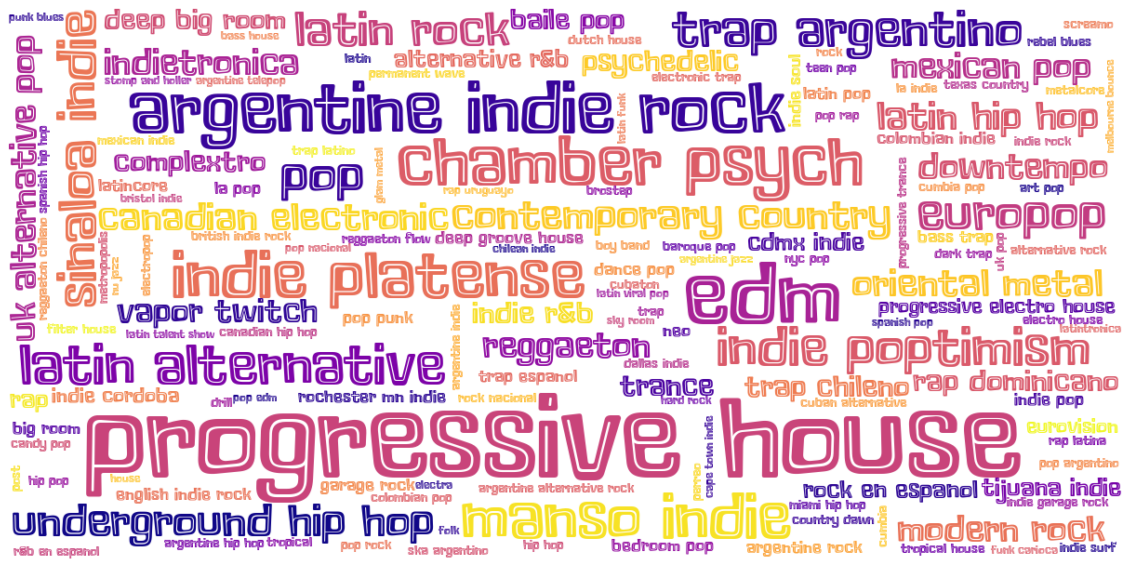

In [21]:
cv = CountVectorizer(token_pattern=r'((?:\w\s?&?)+)-?')
genres = cv.fit_transform(df_artists['genres'].map(lambda x: '-'.join(x)))
genres_freq = pd.DataFrame(genres.todense(),
                           index=df_artists.index, columns=cv.vocabulary_).T.sum(axis=1).to_dict()

# Generate wordcloud
wordcloud = WordCloud(width=1200, height=600, colormap='plasma',
                      background_color='white', font_path='./Lolapeluza-Font/Lolapeluza-Regular.ttf',
                      collocations=False).generate_from_frequencies(genres_freq)

# Visualize wordcloud
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

Genres wordcloud per day

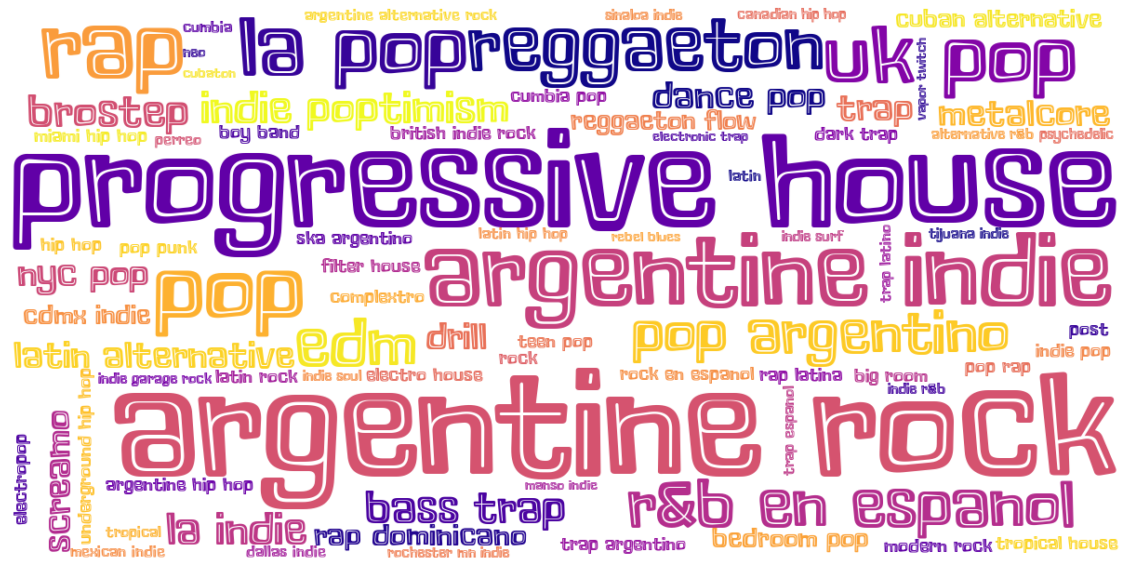

In [22]:
# Day 1
genres_day_1 = cv.fit_transform(df_artists.loc[df_artists['day'] == 1, 'genres'].map(lambda x: '-'.join(x)))
genres_day_1_freq = pd.DataFrame(genres_day_1.todense(),
                                 index=df_artists.loc[df_artists['day'] == 1].index,
                                 columns=cv.vocabulary_).T.sum(axis=1).to_dict()
genres_day_1_freq['rap'] += 3
genres_day_1_freq['progressive house'] += 5

# Generate wordcloud
wordcloud = WordCloud(width=1200, height=600, colormap='plasma',
                      background_color='white', font_path='./Lolapeluza-Font/Lolapeluza-Regular.ttf',
                      collocations=False).generate_from_frequencies(genres_day_1_freq)

# Visualize wordcloud
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

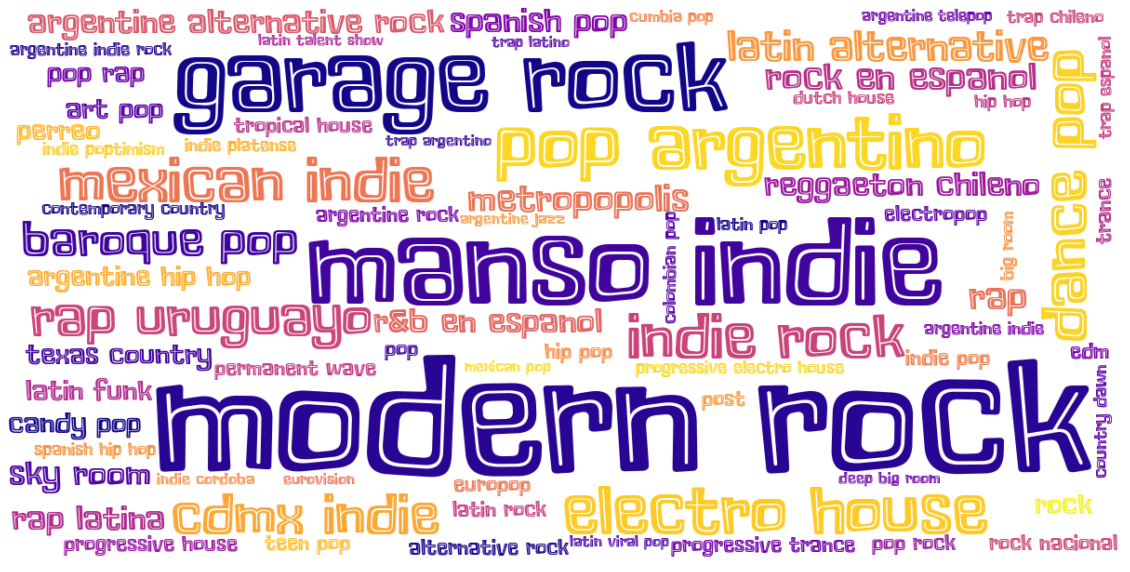

In [23]:
# Day 2
genres_day_2 = cv.fit_transform(df_artists.loc[df_artists['day'] == 2, 'genres'].map(lambda x: '-'.join(x)))
genres_day_2_freq = pd.DataFrame(genres_day_2.todense(),
                                 index=df_artists.loc[df_artists['day'] == 2].index,
                                 columns=cv.vocabulary_).T.sum(axis=1).to_dict()

# Generate wordcloud
wordcloud = WordCloud(width=1200, height=600, colormap='plasma',
                      background_color='white', font_path='./Lolapeluza-Font/Lolapeluza-Regular.ttf',
                      collocations=False).generate_from_frequencies(genres_day_2_freq)

# Visualize wordcloud
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

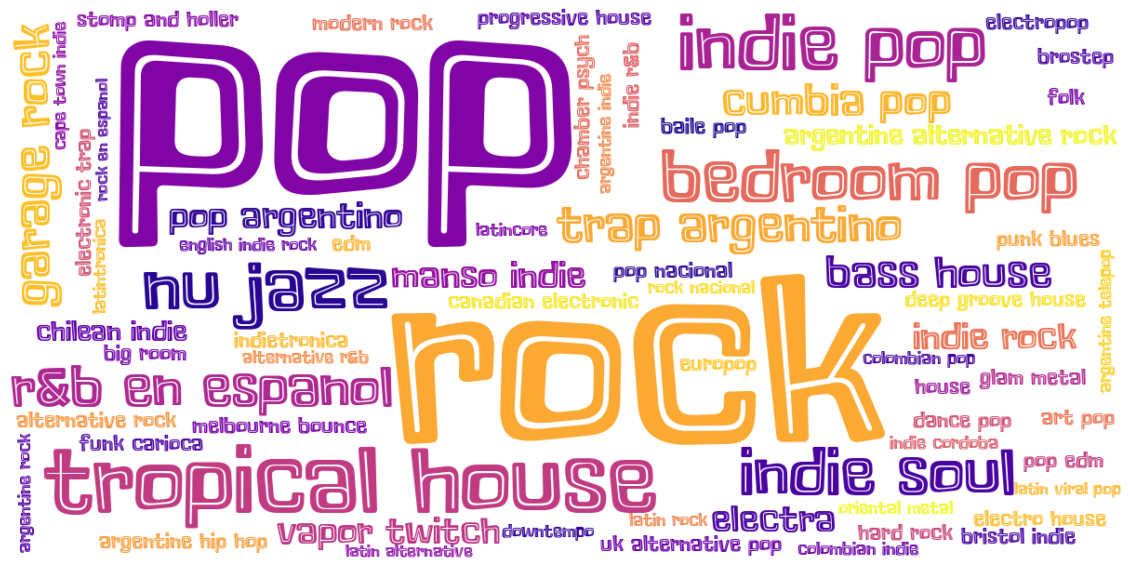

In [24]:
# Day 3
genres_day_3 = cv.fit_transform(df_artists.loc[df_artists['day'] == 3, 'genres'].map(lambda x: '-'.join(x)))
genres_day_3_freq = pd.DataFrame(genres_day_3.todense(),
                                 index=df_artists.loc[df_artists['day'] == 3].index,
                                 columns=cv.vocabulary_).T.sum(axis=1).to_dict()

# Generate wordcloud
wordcloud = WordCloud(width=1200, height=600, colormap='plasma',
                      background_color='white', font_path='./Lolapeluza-Font/Lolapeluza-Regular.ttf',
                      collocations=False).generate_from_frequencies(genres_day_3_freq)

# Visualize wordcloud
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

---

## Artist Clustering

In [26]:
rel_genres_cols = [rel_genre for rel_genre in df_artists.columns if 'related_genre:' in rel_genre]
rel_artist_cols = [rel_artist for rel_artist in df_artists.columns if 'related_artist:' in rel_artist]
cluster_data = df_artists.drop(['artist_id', 'followers', 'popularity', 'albums',
                                'genres', 'related_artists', 'related_genres', 'day',
                                'first_release']+ rel_artist_cols, axis=1)

In [29]:
from sklearn.preprocessing import Normalizer
scaler = StandardScaler()
normalizer = Normalizer()

cluster_data_std = scaler.fit_transform(cluster_data)
cluster_data_l2 = normalizer.fit_transform(cluster_data)

In [30]:
dist =  1 - cosine_similarity(cluster_data_l2)

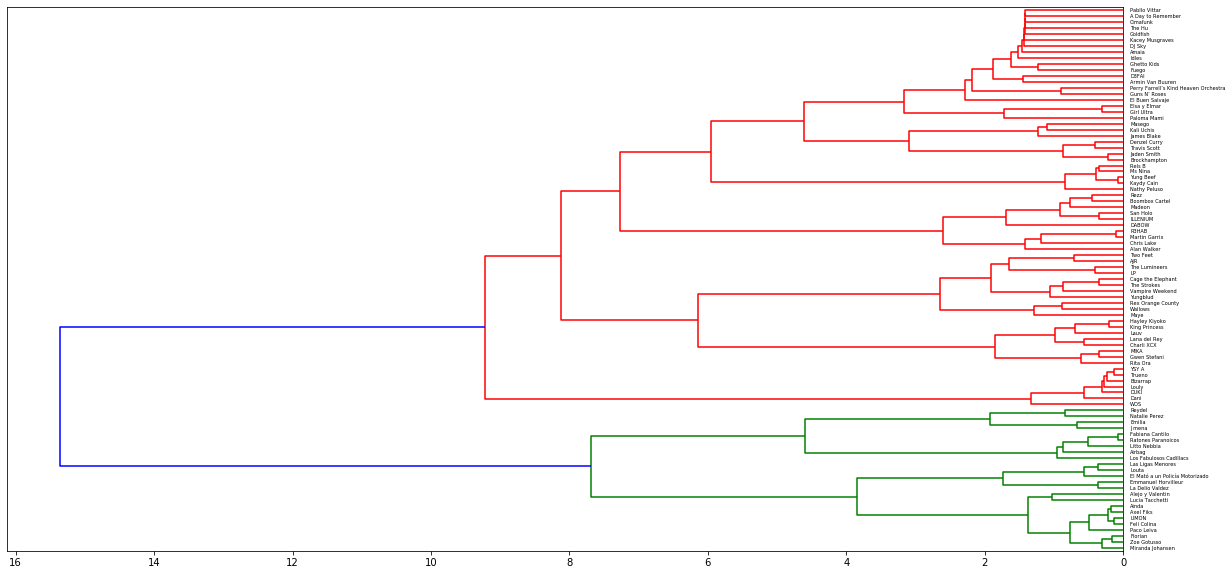

In [32]:
linkage_matrix = linkage(dist, method='ward')
plt.figure(figsize=(20,10))
dendrogram(linkage_matrix, orientation = 'left', labels = df_artists.index)
plt.savefig('dendrogram.svg');

In [33]:
from sklearn.cluster import AgglomerativeClustering

In [34]:
aggcluster = AgglomerativeClustering(n_clusters=15, linkage='average')
aggcluster.fit(cluster_data_std)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=15,
                        pooling_func='deprecated')

In [35]:
for i in range(aggcluster.n_clusters_):
    print('Cluster ', i)
    print(df_artists.index[aggcluster.labels_ == i])

Cluster  0
Index(['Travis Scott', 'Martin Garrix', 'Los Fabulosos Cadillacs',
       'Brockhampton', 'DUKI', 'Madeon', 'Rita Ora', 'King Princess', 'WOS',
       'Yungblud', 'Nathy Peluso', 'J mena', 'AJR', 'Louta', 'Two Feet',
       'Bizarrap', 'La Delio Valdez', 'Dani', 'Kaydy Cain', 'Boombox Cartel',
       'Cimafunk', 'Ms Nina', 'Feli Colina', 'Axel Fiks', 'Lucia Tacchetti',
       'DJ Sky', 'Alejo y Valentin', 'The Strokes', 'Gwen Stefani',
       'Armin Van Buuren', 'Ratones Paranoicos', 'ILLENIUM', 'Kacey Musgraves',
       'Litto Nebbia', 'Charli XCX', 'Jaden Smith', 'R3HAB', 'Hayley Kiyoko',
       'El Mató a un Policía Motorizado', 'Rels B', 'Emmanuel Horvilleur',
       'Kali Uchis', 'Paloma Mami', 'Fabiana Cantilo', 'Trueno', 'Amaia',
       'Wallows', 'Yung Beef', 'Zoe Gotusso', 'Girl Ultra',
       'Las Ligas Menores', 'Ainda', 'Ghetto Kids', 'D3FAI', 'Paco Leiva',
       'LIMON', 'Louly', 'Lana del Rey', 'Cage the Elephant', 'Alan Walker',
       'Rezz', 'Rex Orange Cou

## Viz

In [36]:
import plotly.graph_objects as go
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

In [40]:
tsne = TSNE()
tsne_plot = tsne.fit_transform(cluster_data_l2)

In [65]:
dbscan = DBSCAN(eps=1.5, min_samples=3)
dbscan.fit(tsne_plot)

DBSCAN(algorithm='auto', eps=1.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=3, n_jobs=None, p=None)

In [66]:
data = go.Scatter(x=tsne_plot[:,0], y=tsne_plot[:,1], 
                  mode='markers', 
                  marker=dict(color=dbscan.labels_),
                  hovertext=df_artists.index)
fig = go.Figure(data=data)
fig.show()